<a href="https://colab.research.google.com/github/igcampos/Mestrado/blob/main/saturacao_explicit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
from collections.abc import Iterable
import timeit

In [24]:
#função para o cálculo do modelo Corey - AJUSTADO

def perm_corey(sw,swi,sor,kro_swi,krw_sor,no,nw):
  kro = []
  krw = []

  if isinstance(sw, Iterable):
    #cálculo da permeabilidade relativa do óleo 
    for i in sw:
        kr = kro_swi*((1-sor-i)/(1-swi-sor))**no
        kro.append(kr)
    kro = np.array([kro_swi if i >= 1 else i for i in kro]) #substituindo o valor 1 por kro_swi
    kro[-1] = 0.0 # solução temporária para o erro 

    #cálculo da permeabilidade relativa da água
    for i in sw:
        kr = krw_sor*((i-swi)/(1-swi-sor))**nw
        if kr > krw_sor:
          kr = krw_sor
        krw.append(kr)
    krw = np.array(krw)


  else:
    #cálculo da permeabilidade relativa do óleo
    kr = kro_swi*((1-sor-sw)/(1-swi-sor))**no
    if kr > kro_swi:
      kr = kro_swi
    kro.append(kr)
    kro = np.array(kro) 
    #cálculo da permeabilidade relativa da água 
    kr = krw_sor*((sw-swi)/(1-swi-sor))**nw
    if kr > krw_sor:
      kr = krw_sor
    krw.append(kr)
    krw = np.array(krw)
  
  return kro, krw

#função que calcula a mobilidade em diferentes pontos de saturação
def mobilidade(sw,visc_agua,visc_oleo):

  numerador_da_funcao = perm_corey(sw,swi,sor,kro_swi,krw_sor,no,nw)[1]/visc_agua
  denominador_da_funcao = (perm_corey(sw,swi,sor,kro_swi,krw_sor,no,nw)[1]/visc_agua) + (perm_corey(sw,swi,sor,kro_swi,krw_sor,no,nw)[0]/visc_oleo)
  resultado_mobilidade =  numerador_da_funcao/denominador_da_funcao

  return resultado_mobilidade

In [3]:
#Discretização do domínio 
nx = 100                                                               #Número de pontos do grid
dominio = np.arange(nx)                                                #vetor domínio
print("Número de dimensões: {}".format(dominio.ndim))                  #número de dimensões
print(dominio)

Número de dimensões: 1
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


In [4]:
#Calculo de Delta X
#tamanho do meio poroso
tam_meio_poroso = 5000 #ft
#tamanho do elemento do grid
tam_grid = tam_meio_poroso/nx
#Delta X - normalizado
dx = tam_grid/tam_meio_poroso
print("O tamanho dos elementos do grid em uma malha estruturada é {}, e o delta X é {} ".format(tam_grid, dx))

O tamanho dos elementos do grid em uma malha estruturada é 50.0, e o delta X é 0.01 


In [5]:
#Calculo de Delta T
#viscosidade da água 
visc_agua = 0.5963 #cp
#viscosidade do óleo
visc_oleo = 2 #cp
#velocidade total na injeção 
ut = 0.6 #ft³/d - AVALIAR DEPOIS
#porosidade
porosidade_meio = 0.2
#tempo de simulação 
nt = 720 #dias
#passo de tempo
passo_tempo = 10 #dias
#Delta T - normalizado
dt =  ut*passo_tempo/(tam_meio_poroso*porosidade_meio)
print("O delta T normalizado é {}".format(dt))

O delta T normalizado é 0.006


In [6]:
#Número de Courant
num_Courant = dt/dx # ANALISE DE SENSIBILIDADE DEPOIS
print(f"O número de courant é {num_Courant}")

O número de courant é 0.6


In [7]:
#condição de contorno e inicial
#Condição Inicial Sw(X,0)
sw_CI = 0.2
#Condição de Contorno Sw(0,T)
sw_CC = 0.8
#Matriz de saturação para alocação dos resultados
tempos_de_injecao = int(nt/passo_tempo)   #quantidade representando os tempos de injeção que serão calculados
matriz_resultado_saturacao = np.zeros((tempos_de_injecao,nx)) 
matriz_resultado_saturacao.shape

(72, 100)

In [8]:
#modificando a primeira linha da matriz para alocar os valores das condições iniciais
matriz_resultado_saturacao[0,:] = sw_CI 

In [9]:
matriz_resultado_saturacao[0,:] 

array([0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2])

In [21]:
#Características do sistema molhável a água
#saturação inicial
swi = 0.2
#saturação de óleo residual
sor = 0.2
#permeabilidade relativa da água na saturação residual
krw_sor = 0.3 
#permeabilidade relativa do óleo na saturação residual
kro_swi = 0.85 
#porosidade
porosidade = porosidade_meio
#parâmetros de Corey
no = 1.5
nw = 2

In [11]:
tempos_de_injecao = np.arange(tempos_de_injecao) #utilizado como vetor de tempo para o calculo de saturação
tempos_de_injecao

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71])

In [22]:
#Calculo da saturação e preenchimento da matriz de resultado
#calulo do tempo de execução:
start = timeit.default_timer()
for n in tempos_de_injecao:
  #calculo da primeira linha
  if n == 0:
    for i in dominio:
      if i == 0: 
        #primeiro ponto
        mobilidade_i_menos_meio = mobilidade(sw_CC,visc_agua,visc_oleo)
        mobilidade_i = mobilidade(sw_CI,visc_agua,visc_oleo)
        sw_n_mais_1 = dt/dx*(mobilidade_i_menos_meio - mobilidade_i) + sw_CI
        matriz_resultado_saturacao[n,i] =  sw_n_mais_1
      else:
        #outros ponto
        sw_ajustado =  (matriz_resultado_saturacao[n,i-1] + matriz_resultado_saturacao[n,i])/2
        mobilidade_i_menos_meio = mobilidade(sw_ajustado,visc_agua,visc_oleo)
        mobilidade_i = mobilidade(sw_CI,visc_agua,visc_oleo)
        sw_n_mais_1 = dt/dx * (mobilidade_i_menos_meio - mobilidade_i) + sw_CI
        matriz_resultado_saturacao[n,i] =  sw_n_mais_1
  #Cálculo das demais linhas      
  else:
      for i in dominio:
        if i == 0: 
          #primeiro ponto
          mobilidade_i_menos_meio = mobilidade(sw_CC,visc_agua,visc_oleo)
          mobilidade_i = mobilidade(matriz_resultado_saturacao[n-1,i],visc_agua,visc_oleo)
          sw_n_mais_1 = dt/dx*(mobilidade_i_menos_meio - mobilidade_i) + matriz_resultado_saturacao[n-1,i]
          matriz_resultado_saturacao[n,i] =  sw_n_mais_1
        else:
          #outros ponto
          sw_ajustado =  (matriz_resultado_saturacao[n-1,i-1] + matriz_resultado_saturacao[n-1,i])/2
          mobilidade_i_menos_meio = mobilidade(sw_ajustado,visc_agua,visc_oleo)
          mobilidade_i = mobilidade(matriz_resultado_saturacao[n-1,i],visc_agua,visc_oleo)
          sw_n_mais_1 = dt/dx * (mobilidade_i_menos_meio - mobilidade_i) + matriz_resultado_saturacao[n-1,i]
          matriz_resultado_saturacao[n,i] =  sw_n_mais_1
stop = timeit.default_timer()
print('Tempo de execução: {} segundos'.format(stop-start))

Tempo de execução: 0.3990954050000255 segundos


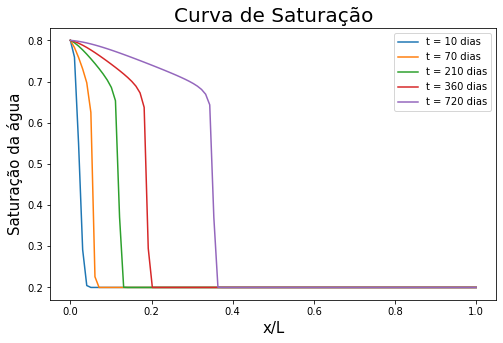

In [23]:
#plotar os resultados
vetor_comprimento = np.linspace(0, 1, nx)
fig = plt.figure(figsize=(8,5))
ax = plt.subplot(1,1,1)
ax.plot(vetor_comprimento, matriz_resultado_saturacao[0], label = "t = 10 dias")
ax.plot(vetor_comprimento, matriz_resultado_saturacao[6], label = "t = 70 dias")
ax.plot(vetor_comprimento, matriz_resultado_saturacao[20], label = "t = 210 dias")
ax.plot(vetor_comprimento, matriz_resultado_saturacao[35], label = "t = 360 dias")
ax.plot(vetor_comprimento, matriz_resultado_saturacao[71], label = "t = 720 dias")

ax.set_xlabel("x/L", fontsize=15)
ax.set_ylabel("Saturação da água", fontsize=15)
plt.title("Curva de Saturação", fontsize=20)
ax.legend()
plt.show()